# RSI

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def calculate_qqe_rsi_trailing_stop(financial_data: pd.DataFrame, record_to_plot: int = None, length=5, factor=4.236, smooth=60):
    # Read financial data
    financial_data = financial_data[:record_to_plot]
    # make column named signal
    financial_data["signal"] = 0
    close_prices = financial_data['Close'].values

    # Calculate RSI
    delta = np.diff(close_prices)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = np.mean(gain[:length])
    avg_loss = np.mean(loss[:length])

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    for i in range(length, len(close_prices)):
        delta = close_prices[i] - close_prices[i - 1]
        gain = max(delta, 0)
        loss = -min(delta, 0)

        avg_gain = ((length - 1) * avg_gain + gain) / length
        avg_loss = ((length - 1) * avg_loss + loss) / length

        rs = avg_gain / avg_loss
        rsi = np.append(rsi, 100 - (100 / (1 + rs)))

    # Calculate Trailing Stop
    # Calculate the difference between consecutive RSI values
    rsi_diff = np.diff(rsi)

    crossover = np.where(rsi > 0, 1, 0)
    crossunder = np.where(rsi < 0, 1, 0)

    close_prices = close_prices[:-1]
    crossunder = crossunder[:-1]

    ts = np.zeros_like(rsi)  # Initialize ts with zeros
    crossover = crossover[:-1]
    for i in range(1, len(rsi)-1):
        if crossover[i]:
            ts[i] = rsi[i] - np.abs(rsi_diff[i]) * factor
        elif crossunder[i]:
            ts[i] = rsi[i] + np.abs(rsi_diff[i]) * factor
        else:
            if rsi[i] > ts[i - 1]:
                ts[i] = max(rsi[i] - np.abs(rsi_diff[i]) * factor, ts[i - 1])
            else:
                ts[i] = min(rsi[i] + np.abs(rsi_diff[i]) * factor, ts[i - 1])

    for i in range(1, len(ts)):
        ts[i] = ts[i] / 100 * close_prices[i] + (1 - ts[i] / 100) * ts[i - 1]
        rsi[i] = rsi[i] / 100 * close_prices[i] + \
            (1 - rsi[i] / 100) * rsi[i - 1]

    # Smooth RSI
    smoothed_rsi = np.convolve(rsi, np.ones(smooth)/smooth, mode='valid')
    smoothed_rsi = np.concatenate(
        (rsi[:smooth-1], smoothed_rsi))  # Preserve original length
    
    # start plotting
    plt.figure(figsize=(10, 6))
    plt.plot(close_prices[smooth:], label='Close Price')
    last_signal = None
    for i in range(1, len(smoothed_rsi)):
        # if the smoothed rsi is greater than the trailing stop, buy
        if last_signal == None:
            if smoothed_rsi[i] > ts[i] and i+smooth < len(close_prices):
                plt.plot(i, close_prices[i+smooth], marker='o', color='red')
                last_signal = 'buy'
                financial_data.loc[i, "signal"] = 2
            else:
                plt.plot(i, close_prices[i+smooth], marker='o', color='green')
                last_signal = 'sell'
                financial_data.loc[i, "signal"] = 1
        if smoothed_rsi[i] > ts[i] and i+smooth < len(close_prices):
            if last_signal != 'buy':
                plt.plot(i, close_prices[i+smooth], marker='o', color='red')
                last_signal = 'buy'
                financial_data.loc[i, "signal"] = 2
        # if the smoothed rsi is less than the trailing stop, sell
        if smoothed_rsi[i] < ts[i] and i+smooth < len(close_prices):
            if last_signal != 'sell':
                plt.plot(i, close_prices[i+smooth], marker='o', color='green')
                last_signal = 'sell'
                financial_data.loc[i, "signal"] = 1
    # Increase smoothness of the trailing stop

    # Plot the results
    if record_to_plot is not None:
        plt.plot(smoothed_rsi[smooth+2:], label='Trailing Stop')
        plt.legend(loc='upper left')
        plt.show()

    return financial_data

# Activation

In [3]:
financial_data = pd.read_csv("..\data\EURUSD_Candlestick_4_Hour_ASK_05.05.2003-16.10.2021.csv")

# delete dollar sign
try:
    # Clean up dollar signs and convert columns to numeric values
    financial_data["Close/Last"] = financial_data["Close/Last"].str.replace(
        "$", "").astype(float)
    financial_data["Open"] = financial_data["Open"].str.replace(
        "$", "").astype(float)
    financial_data["High"] = financial_data["High"].str.replace(
        "$", "").astype(float)
    financial_data["Low"] = financial_data["Low"].str.replace(
        "$", "").astype(float)
except Exception:
    pass

# rename the headers
try:
    financial_data.rename(columns={"Close/Last": "Close"}, inplace=True)
except Exception:
    pass


In [4]:
financial_data.rename(columns={"high": "High"}, inplace=True)
financial_data.rename(columns={"low": "Low"}, inplace=True)
financial_data.rename(columns={"open": "Open"}, inplace=True)
financial_data.rename(columns={"volume": "Volume"}, inplace=True)
financial_data.rename(columns={"close": "Close"}, inplace=True)


financial_data = financial_data.reset_index(drop=True)

C:\Users\bobek\AppData\Local\Temp\ipykernel_5092\3663550782.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_data["signal"] = 0


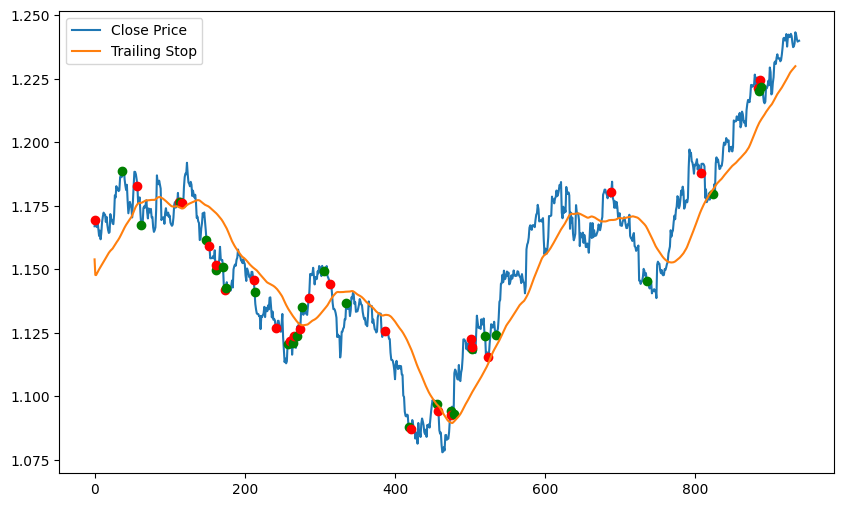

In [5]:
financial_data = calculate_qqe_rsi_trailing_stop(financial_data, record_to_plot=1000)


In [6]:
from apply_backtesting import backtester
import backtesting

# import output_notebook
from bokeh.io import output_notebook
output_notebook()

backtesting.set_bokeh_output(notebook=True)


bt,stats = backtester(financial_data)
bt.run()
bt.plot()


Loading BokehJS ...

c:\Users\bobek\QuantWiseAI\jupiter_notebooks\apply_backtesting.py:34: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(financial_data, MyCandlesStrat, cash=10_000, commission=.00)


25
25


Row(id='1456', ...)

## Results

- Return: 17.3%
- Buy & Hold Return: 10.6%
- Win Rate: 95%


In [7]:
print(stats)

Start                                     0.0
End                                     999.0
Duration                                999.0
Exposure Time [%]                        88.6
Equity Final [$]                  11731.37414
Equity Peak [$]                   11731.37414
Return [%]                          17.313741
Buy & Hold Return [%]               10.624009
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -5.499839
Avg. Drawdown [%]                   -0.704071
Max. Drawdown Duration                  197.0
Avg. Drawdown Duration              18.282609
# Trades                                 20.0
Win Rate [%]                             95.0
Best Trade [%]                       4.018798
Worst Trade [%]                     -0.088929
Avg. Trade [%]                    